In [1]:
# Import relevant packages
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
import seaborn as sns
from netCDF4 import Dataset
from datetime import date, timedelta
import time

In [2]:
### Monthly wind data was dowloaded in decades from 1990-2021 ###
# Read 1990-1999 data
ds1 = Dataset('adaptor.mars.internal-1659274169.785255-14692-14-6772cd1c-fba8-4f53-973d-c5a606620ac9.nc')
# Read 2000-2009 data
ds2 = Dataset('adaptor.mars.internal-1659276992.292069-3104-3-09456479-0532-4bb5-b7e8-d157b5012661.nc')
# Read 2010-2019 data
ds3 = Dataset('adaptor.mars.internal-1659280170.6342864-20288-14-99611ce1-690a-416d-a8ed-5b85d97dab5d.nc')
# Read 2020-2021 data
ds4 = Dataset('adaptor.mars.internal-1659280363.5648322-6851-10-51138dca-7541-4f0b-b3fe-2feb7df862fd.nc')

In [3]:
# Print wind speed metadata
print(ds1.variables['si10'])

<class 'netCDF4._netCDF4.Variable'>
int16 si10(time, latitude, longitude)
    scale_factor: 0.0003116127054281623
    add_offset: 10.56556001324453
    _FillValue: -32767
    missing_value: -32767
    units: m s**-1
    long_name: 10 metre wind speed
unlimited dimensions: 
current shape = (120, 721, 1440)
filling on


In [4]:
# Make list of data sets
dss = [ds1, ds2, ds3, ds4]

In [7]:
# Get data latitudes
lats = np.ma.getdata(ds4.variables['latitude'])[:]
# Get data longitudes and shift by 180 degree 
lons = np.ma.getdata(ds4.variables['longitude'])[:] - 180

In [8]:
print(lons)

[-180.   -179.75 -179.5  ...  179.25  179.5   179.75]


<AxesSubplot:>

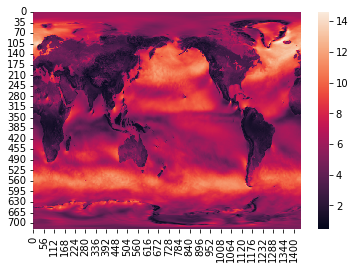

In [17]:
# Plot current data to view orientation/shift
sns.heatmap(np.ma.getdata(ds4.variables['si10'])[0,:,:])

1440


<AxesSubplot:>

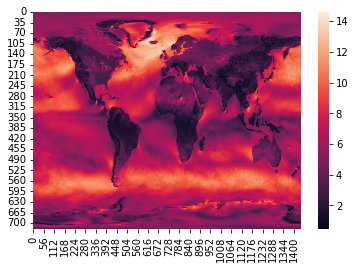

In [18]:
# Print shape (length) of longitude 
print(ds4['si10'].shape[2])
# Get data from one time index
org_data = np.ma.getdata(ds4.variables['si10'])[0,:,:]
# Switch halves of data
switch_data = np.concatenate((org_data[:, 720:], org_data[:, :720]), axis=1)
# Print new data as a check
sns.heatmap(switch_data)

In [71]:
# Set reference date (from time metadata)
start_date = date(1900,1,1)

# Loop over data sets in data set list
for n,current_ds in enumerate(dss):
    # Set starting index for data set
    start_num = 0
    # Loop over time indexes in data set
    for i in range(start_num,current_ds['si10'].shape[0],1):
        
        # Start timer to track loop time
        start_time = time.time()
        
        # Get time shift
        t_diff = float(np.ma.getdata(current_ds['time'])[i])
        # Find current date being investigated
        new_date = start_date + timedelta(hours=t_diff)
        # Print current date
        print(new_date, end=' ')
        
        # Get wind speed values at this time index
        wind_vals = current_ds['si10'][i,:,:]
        # Switch halves of wind speed data
        wind_vals = np.concatenate((wind_vals[:, 720:], wind_vals[:, :720]), axis=1)
        # Print success message
        print('data retrieved', end=' -> ')
        
        # Make Dataframe to hold wind speed values indexed by coordinates
        one_month_data = pd.DataFrame(data=wind_vals, index=lats, columns=lons)

        # Initialise a 1x1 degree grid of zeros
        one_deg_grid = np.zeros((len(range(90,-90,-1)),len(range(-180,180,1))))

        # Loop over latitudes - increments of 1-degree
        for lat_ind,latitude in enumerate(range(90,-90,-1)):
            # Loop over longitudes - increments of 1-degree
            for lon_ind,longitude in enumerate(range(-180,180,1)):

                # Get 1x1 degree square of values 
                # If/elif statements catch edge values to ensure all data is used
                if (longitude == 179) and (latitude == -89):
                    one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index >= latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns <= longitude+1)])

                elif (longitude == 179):
                    one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index > latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns <= longitude+1)])

                elif (latitude == -89):
                    one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index >= latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns < longitude+1)])

                else:
                    one_deg_square = np.asarray(one_month_data.loc[(one_month_data.index <= latitude) & (one_month_data.index > latitude-1),(one_month_data.columns >= longitude) & (one_month_data.columns < longitude+1)])

                
                # If all values in square are NaN, set the square mean and NaN
                if np.isnan(one_deg_square).all() == True:
                    one_deg_mean = np.nan
                # Else set to the mean of the values in the square (excluding NaNs)
                else:
                    one_deg_mean = np.nanmean(one_deg_square)

                # Overwrite zeros grid with wind speed mean at current coordinate indexes
                one_deg_grid[lat_ind, lon_ind] = one_deg_mean


        # If on first iteration of loop intialise 3D array to hold averaged data
        if i == start_num:
            wind_LR_data = one_deg_grid
        # Else append average data to 3D array
        else:
            wind_LR_data = np.dstack((wind_LR_data, one_deg_grid))
        
        # End loop timer
        end_time = time.time()
        
        # Print current shape of 3D array as a check, as well as loop total time
        print(wind_LR_data.shape, round(end_time-start_time,3))
        
    # If on first data set (file) initialise a 3D array to hold data from all files
    if n == 0:
        wind_stack = wind_LR_data
    # Else append data sets to 3D array
    else:
        wind_stack = np.dstack((wind_stack, wind_LR_data))   
    
    # Print final wind speed average data shape as a check
    print(f"##########\n{wind_stack.shape}\n#########")

In [74]:
# Loop to flatten data for saving to CSV
for i in range(0, wind_stack.shape[2]):
    if i == 0:
        wind_flat = wind_stack[:,:,i]
    else:
        wind_slice = wind_stack[:,:,i]
        wind_flat = np.concatenate((wind_flat,wind_slice), axis=0)

# Print shape of flattened data as a check
print(wind_flat.shape)

# Save wind data to CSV
np.savetxt('wind_LR_flat.csv', wind_flat, delimiter=',')

(69120, 360)